# Previsões em Dados Novos com Backtest e Filtro Powell

Este notebook faz previsões em dados novos com os mesmos parâmetros do backtest do Deep Learning BTC.
Inclui o filtro Powell e análise de trades simulados.

## 1. Importar Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import os
import json
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

print("✓ Bibliotecas importadas com sucesso")

✓ Bibliotecas importadas com sucesso


## 2. Carregar Modelo e Dados

In [2]:
# Definir diretórios
DATA_DIR = "data"

# Caminhos
MODEL_PATH = os.path.join(DATA_DIR, "model_cnn_lstm_selected.keras")
SCALER_PATH = os.path.join(DATA_DIR, "scaler.pkl")
SPLIT_JSON_PATH = os.path.join(DATA_DIR, "split_boundaries.json")
SELECTED_FEATURES_PATH = os.path.join(DATA_DIR, "selected_features.txt")
IN_CLEAN = os.path.join(DATA_DIR, "merged_btc_features_CLEAN_real.csv")
POWELL_CSV = os.path.join(DATA_DIR, "powell_classificacoes.csv")

# Carregar modelo
model = keras.models.load_model(MODEL_PATH)
print(f"✓ Modelo carregado")

# Carregar scaler
with open(SCALER_PATH, "rb") as f:
    scaler = pickle.load(f)

if not hasattr(scaler, 'transform'):
    print("⚠️ Recriando scaler...")
    from sklearn.preprocessing import StandardScaler as SS
    df_train = pd.read_csv(IN_CLEAN, parse_dates=["date"])
    with open(SPLIT_JSON_PATH, "r") as f:
        config = json.load(f)
    train_end = config["TRAIN_END"]
    df_train = df_train[df_train["date"] <= train_end]
    features = config["FEATURE_COLS"]
    for col in features:
        df_train[col] = pd.to_numeric(df_train[col], errors="coerce")
    scaler = SS()
    scaler.fit(df_train[features].values)

print(f"✓ Scaler carregado")

# Carregar configurações
with open(SPLIT_JSON_PATH, "r") as f:
    split_meta = json.load(f)

lookback = split_meta["LOOKBACK"]
feature_cols = split_meta["FEATURE_COLS"]

# Carregar features selecionadas
with open(SELECTED_FEATURES_PATH, "r") as f:
    selected_features = [line.strip() for line in f.readlines()]

# Carregar dados
df_clean = pd.read_csv(IN_CLEAN, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
powell = pd.read_csv(POWELL_CSV, parse_dates=["date"])

print(f"✓ Configurações carregadas:")
print(f"  - LOOKBACK: {lookback}")
print(f"  - Features: {len(feature_cols)}")
print(f"  - Features selecionadas: {len(selected_features)}")

✓ Modelo carregado
⚠️ Recriando scaler...
✓ Scaler carregado
✓ Configurações carregadas:
  - LOOKBACK: 30
  - Features: 22
  - Features selecionadas: 15


In [3]:
df_clean = df_clean.loc[df_clean['date'] >= "2024-12-20"].reset_index(drop=True)
df_clean

,date,open,high,low,close,volume,quote_volume,trades,taker_buy_base,taker_buy_quote,...,active_addresses,difficulty,hash_rate_y,blk_size_mean,miners_revenue_usd,tx_count_day,market_cap_usd,tx_volume_usd,nvt,target
0,2024-12-20,97434.3,98243.0,92272.6,97764.4,396188.795,3.795873e+10,7747092,192090.031,1.840461e+10,...,882836.0,1.085226e+14,8.145982e+08,623886.479564,4.879208e+07,398670.0,1.895515e+12,1.613380e+10,117.487193,0
1,2024-12-21,97764.5,99485.0,96375.0,97261.8,161258.480,1.575850e+10,3335893,80347.265,7.853654e+09,...,744752.0,1.085226e+14,7.822301e+08,624119.948773,4.657698e+07,330225.0,1.931990e+12,6.882358e+09,280.716291,0
2,2024-12-22,97261.7,97437.9,94200.0,95153.5,148114.735,1.421596e+10,3134938,70507.415,6.767629e+09,...,758970.0,1.085226e+14,8.361770e+08,624354.864832,4.865790e+07,336217.0,1.894495e+12,3.340023e+09,567.210198,0
3,2024-12-23,95153.4,96499.0,92464.4,94861.1,247211.855,2.335244e+10,5207668,121829.032,1.151020e+10,...,804969.0,1.085226e+14,7.498619e+08,624609.250620,4.214259e+07,292681.0,1.851951e+12,1.247353e+10,148.470477,1
4,2024-12-24,94861.0,99450.0,93525.6,98627.2,211610.632,2.046719e+10,3920298,109376.056,1.058088e+10,...,763920.0,1.085226e+14,7.120991e+08,624841.657051,4.047510e+07,326570.0,1.951980e+12,1.156406e+10,168.797113,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,2025-10-30,109985.6,111565.1,106200.0,108263.5,205753.644,2.236911e+10,6330320,100086.671,1.088224e+10,...,708971.0,1.559730e+14,1.240554e+09,696474.887771,4.636676e+07,554058.0,2.193612e+12,1.300415e+10,170.692619,1
315,2025-10-31,108263.6,111233.0,108226.6,109557.3,152063.776,1.668380e+10,4790937,78106.793,8.570620e+09,...,723709.0,1.559730e+14,1.085485e+09,696708.441787,4.636676e+07,460063.0,2.193612e+12,1.300415e+10,170.692619,1
316,2025-11-01,109557.2,110557.0,109351.5,110047.2,41614.221,4.579669e+09,1492868,21133.219,2.325832e+09,...,683092.0,1.559730e+14,1.069978e+09,696927.571552,4.636676e+07,391320.0,2.193612e+12,1.300415e+10,170.692619,1
317,2025-11-02,110047.3,111216.0,109368.9,110494.9,61109.173,6.744088e+09,2070247,29327.591,3.237152e+09,...,575622.0,1.559730e+14,1.201787e+09,697157.209676,4.636676e+07,408092.0,2.193612e+12,1.300415e+10,170.692619,0


## 3. Pré-processar Dados Novos

In [4]:
def preprocess_new_data(df, scaler, feature_cols, selected_features, lookback):
    """Pré-processa dados novos com os mesmos passos do treinamento."""
    
    df["date"] = pd.to_datetime(df["date"], utc=True).dt.tz_localize(None)
    df = df.sort_values("date").reset_index(drop=True)
    
    # Selecionar colunas (close não está em feature_cols, então não haverá duplicação)
    cols_to_select = ["date", "close"]
    for col in feature_cols:
        if col not in cols_to_select:
            cols_to_select.append(col)
    
    df = df[cols_to_select].copy()
    
    for col in feature_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    df[feature_cols] = df[feature_cols].ffill()
    df = df.dropna(subset=feature_cols).reset_index(drop=True)
    
    def ema_smooth(series, span=7):
        return series.ewm(span=span, adjust=False).mean()
    
    for col in feature_cols:
        df[col] = ema_smooth(df[col])
    
    df = df.dropna(subset=feature_cols).reset_index(drop=True)
    
    X_scaled = scaler.transform(df[feature_cols].values)
    
    selected_idx = [feature_cols.index(f) for f in selected_features if f in feature_cols]
    X_selected = X_scaled[:, selected_idx]
    
    X_sequences = []
    dates = []
    closes = []
    
    for i in range(lookback - 1, len(X_selected)):
        X_sequences.append(X_selected[i - lookback + 1 : i + 1, :])
        dates.append(df["date"].iloc[i])
        closes.append(df["close"].iloc[i])
    
    return np.array(X_sequences), np.array(dates), np.array(closes)

print("✓ Função de preprocessing definida")

✓ Função de preprocessing definida


## 4. Fazer Previsões em Dados Novos

In [5]:
# Pré-processar dados
df_new = df_clean.copy()
X_sequences, pred_dates, pred_closes = preprocess_new_data(
    df_new, scaler, feature_cols, selected_features, lookback
)

print(f"✓ Dados preparados:")
print(f"  Shape: {X_sequences.shape}")
print(f"  Datas: {pred_dates[0].date()} → {pred_dates[-1].date()}")

# Fazer previsões
prob_new = model.predict(X_sequences, verbose=0).ravel()

print(f"✓ Previsões realizadas")
print(f"  Probabilidade média: {prob_new.mean():.3f}")
print(f"  Min/Max: {prob_new.min():.3f} / {prob_new.max():.3f}")

✓ Dados preparados:
  Shape: (290, 30, 15)
  Datas: 2025-01-18 → 2025-11-03
✓ Previsões realizadas
  Probabilidade média: 0.583
  Min/Max: 0.544 / 0.634


## 5. Encontrar Melhor Threshold (do Validation Set)

In [6]:
# Carregar dados de validação para calibrar threshold
TRAIN_END = pd.Timestamp(split_meta["TRAIN_END"])
VAL_END = pd.Timestamp(split_meta["VAL_END"])

val_df = df_clean[(df_clean["date"] > TRAIN_END) & (df_clean["date"] <= VAL_END)].copy()
val_df = val_df.sort_values("date").reset_index(drop=True)

# Pré-processar validação
X_val_seq, _, _ = preprocess_new_data(
    val_df, scaler, feature_cols, selected_features, lookback
)

# Carregar targets de validação
df_clean_for_target = df_clean.copy()
df_clean_for_target["target"] = (df_clean_for_target["close"].shift(-1) > df_clean_for_target["close"]).astype(int)

val_target_df = df_clean_for_target[(df_clean_for_target["date"] > TRAIN_END) & (df_clean_for_target["date"] <= VAL_END)]
y_val = val_target_df["target"].values[lookback-1:]

# Fazer previsões no validation
prob_val = model.predict(X_val_seq, verbose=0).ravel()

# Encontrar melhor threshold
def find_best_threshold(y_true, prob):
    thresholds = np.linspace(0.1, 0.9, 81)
    best_t, best_mcc = 0.5, -1.0
    for t in thresholds:
        pred = (prob >= t).astype(int)
        mcc = matthews_corrcoef(y_true, pred)
        if mcc > best_mcc:
            best_mcc, best_t = mcc, t
    return best_t, best_mcc

t_best, mcc_best = find_best_threshold(y_val, prob_val)

print(f"✓ Threshold calibrado:")
print(f"  Threshold: {t_best:.3f}")
print(f"  MCC: {mcc_best:.4f}")

# Aplicar threshold
pred_new = (prob_new >= t_best).astype(int)

✓ Threshold calibrado:
  Threshold: 0.560
  MCC: 0.1667


## 6. Aplicar Filtro Powell

In [7]:
# Preparar sinal Powell com forward fill
powell_signal = pd.DataFrame({
    "date": pred_dates,
    "powell_class": 0  # default neutro
})

powell_sorted = powell[["date", "classificacao"]].sort_values("date").reset_index(drop=True)

for idx, row in powell_signal.iterrows():
    current_date = row["date"]
    recent = powell_sorted[powell_sorted["date"] <= current_date].sort_values("date", ascending=False)
    if not recent.empty:
        powell_signal.loc[idx, "powell_class"] = int(recent.iloc[0]["classificacao"])

print(f"✓ Filtro Powell aplicado:")
print(f"  Positivo (1): {np.sum(powell_signal['powell_class'] == 1)}")
print(f"  Neutro (0): {np.sum(powell_signal['powell_class'] == 0)}")
print(f"  Negativo (-1): {np.sum(powell_signal['powell_class'] == -1)}")

✓ Filtro Powell aplicado:
  Positivo (1): 51
  Neutro (0): 76
  Negativo (-1): 163


## 7. Executar Backtest com Filtro Powell

In [8]:
def run_backtest_with_powell_filter(dates, closes, predictions, powell_signal):
    """
    Regras:
    - Long quando pred=1 E powell_class=1
    - Short quando pred=0 E powell_class=-1
    - Sem posição quando powell_class=0
    """
    
    results = {
        "date": [],
        "close": [],
        "pred": [],
        "powell_class": [],
        "position": [],
        "entry_price": [],
        "exit_price": [],
        "pnl": [],
        "return_pct": []
    }
    
    position = 0
    entry_price = 0
    trades_log = []
    
    for i in range(len(dates)):
        date = dates[i]
        close = closes[i]
        pred = int(predictions[i])
        powell = int(powell_signal.iloc[i]["powell_class"])
        
        pnl = 0
        exit_price = 0
        
        if position == 0:
            if pred == 1 and powell == 1:
                position = 1
                entry_price = close
            elif pred == 0 and powell == -1:
                position = -1
                entry_price = close
        
        elif position == 1:
            if pred == 0:
                exit_price = close
                pnl = exit_price - entry_price
                return_pct = (pnl / entry_price) * 100 if entry_price != 0 else 0
                trades_log.append({
                    "type": "LONG",
                    "entry_date": results["date"][-1] if results["date"] else date,
                    "exit_date": date,
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "pnl": pnl,
                    "return_pct": return_pct
                })
                position = 0
        
        elif position == -1:
            if pred == 1:
                exit_price = close
                pnl = entry_price - exit_price
                return_pct = (pnl / entry_price) * 100 if entry_price != 0 else 0
                trades_log.append({
                    "type": "SHORT",
                    "entry_date": results["date"][-1] if results["date"] else date,
                    "exit_date": date,
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "pnl": pnl,
                    "return_pct": return_pct
                })
                position = 0
        
        results["date"].append(date)
        results["close"].append(close)
        results["pred"].append(pred)
        results["powell_class"].append(powell)
        results["position"].append(position)
        results["entry_price"].append(entry_price if position != 0 else np.nan)
        results["exit_price"].append(exit_price if exit_price != 0 else np.nan)
        results["pnl"].append(pnl if exit_price != 0 else np.nan)
        results["return_pct"].append(return_pct if exit_price != 0 else np.nan)
    
    if position != 0:
        close = closes[-1]
        if position == 1:
            pnl = close - entry_price
            return_pct = (pnl / entry_price) * 100
            trades_log.append({
                "type": "LONG (UNCLOSED)",
                "entry_date": results["date"][-2] if len(results["date"]) > 1 else dates[-1],
                "exit_date": dates[-1],
                "entry_price": entry_price,
                "exit_price": close,
                "pnl": pnl,
                "return_pct": return_pct
            })
        elif position == -1:
            pnl = entry_price - close
            return_pct = (pnl / entry_price) * 100
            trades_log.append({
                "type": "SHORT (UNCLOSED)",
                "entry_date": results["date"][-2] if len(results["date"]) > 1 else dates[-1],
                "exit_date": dates[-1],
                "entry_price": entry_price,
                "exit_price": close,
                "pnl": pnl,
                "return_pct": return_pct
            })
    
    return pd.DataFrame(results), pd.DataFrame(trades_log)

# Executar backtest
backtest_df, trades_df = run_backtest_with_powell_filter(
    pred_dates, pred_closes, pred_new, powell_signal
)

print("✓ Backtest executado com sucesso")

✓ Backtest executado com sucesso


## 8. Resumo do Backtest

In [9]:
print("\n" + "="*80)
print("BACKTEST RESUMO - DADOS NOVOS")
print("="*80)
print(f"\nPeríodo: {pd.Timestamp(pred_dates[0]).date()} a {pd.Timestamp(pred_dates[-1]).date()}")
print(f"Total de dias: {len(pred_dates)}")

print(f"\nDistribuição de sinais (pred):")
print(f"  Long (1): {np.sum(pred_new == 1)}")
print(f"  Short (0): {np.sum(pred_new == 0)}")

print(f"\nDistribuição Powell:")
print(f"  Positivo (1): {np.sum(powell_signal['powell_class'] == 1)}")
print(f"  Neutro (0): {np.sum(powell_signal['powell_class'] == 0)}")
print(f"  Negativo (-1): {np.sum(powell_signal['powell_class'] == -1)}")

print(f"\n--- TRADES EXECUTADOS ---")
print(f"Total de trades: {len(trades_df)}")

if len(trades_df) > 0:
    print(f"\nÚltimos trades:")
    for idx in range(max(0, len(trades_df)-5), len(trades_df)):
        trade = trades_df.iloc[idx]
        print(f"\nTrade {idx+1}:")
        print(f"  Tipo: {trade['type']}")
        print(f"  Entry: {pd.Timestamp(trade['entry_date']).date()} @ ${trade['entry_price']:.2f}")
        print(f"  Exit:  {pd.Timestamp(trade['exit_date']).date()} @ ${trade['exit_price']:.2f}")
        print(f"  P&L: ${trade['pnl']:.2f} ({trade['return_pct']:+.2f}%)")
    
    total_pnl = trades_df["pnl"].sum()
    avg_return = trades_df["return_pct"].mean()
    winning_trades = len(trades_df[trades_df["pnl"] > 0])
    losing_trades = len(trades_df[trades_df["pnl"] < 0])
    win_rate = (winning_trades / len(trades_df) * 100) if len(trades_df) > 0 else 0
    
    print(f"\n--- PERFORMANCE SUMMARY ---")
    print(f"Total P&L: ${total_pnl:+.2f}")
    print(f"Avg Return per Trade: {avg_return:+.2f}%")
    print(f"Win Rate: {win_rate:.1f}% ({winning_trades}W / {losing_trades}L)")
    
    if len(trades_df[trades_df['pnl'] > 0]) > 0:
        print(f"Largest Win: ${trades_df['pnl'].max():.2f} ({trades_df['return_pct'].max():+.2f}%)")
    if len(trades_df[trades_df['pnl'] < 0]) > 0:
        print(f"Largest Loss: ${trades_df['pnl'].min():.2f} ({trades_df[trades_df['pnl'] < 0]['return_pct'].min():+.2f}%)")
    
    gross_profit = trades_df[trades_df["pnl"] > 0]["pnl"].sum()
    gross_loss = abs(trades_df[trades_df["pnl"] < 0]["pnl"].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    print(f"Profit Factor: {profit_factor:.2f}")
else:
    print("Nenhum trade executado no período!")

print(f"\n--- ÚLTIMAS 10 LINHAS DO BACKTEST ---")
print(backtest_df[["date", "close", "pred", "powell_class", "position"]].tail(10).to_string())

# Salvar resultados
backtest_df.to_csv(os.path.join(DATA_DIR, "backtest_results_new.csv"), index=False)
trades_df.to_csv(os.path.join(DATA_DIR, "backtest_trades_new.csv"), index=False)
print(f"\n✓ Resultados salvos em data/backtest_results_new.csv")
print(f"✓ Trades salvos em data/backtest_trades_new.csv")


BACKTEST RESUMO - DADOS NOVOS

Período: 2025-01-18 a 2025-11-03
Total de dias: 290

Distribuição de sinais (pred):
  Long (1): 246
  Short (0): 44

Distribuição Powell:
  Positivo (1): 51
  Neutro (0): 76
  Negativo (-1): 163

--- TRADES EXECUTADOS ---
Total de trades: 5

Últimos trades:

Trade 1:
  Tipo: SHORT
  Entry: 2025-01-21 @ $100467.44
  Exit:  2025-01-22 @ $102664.99
  P&L: $-2197.55 (-2.19%)

Trade 2:
  Tipo: SHORT
  Entry: 2025-02-02 @ $102903.58
  Exit:  2025-02-03 @ $101280.37
  P&L: $1623.21 (+1.58%)

Trade 3:
  Tipo: LONG
  Entry: 2025-04-07 @ $83687.99
  Exit:  2025-04-08 @ $80223.51
  P&L: $-3464.48 (-4.14%)

Trade 4:
  Tipo: LONG
  Entry: 2025-06-23 @ $87254.26
  Exit:  2025-06-24 @ $104379.66
  P&L: $17125.40 (+19.63%)

Trade 5:
  Tipo: SHORT
  Entry: 2025-06-27 @ $105104.74
  Exit:  2025-06-28 @ $106250.56
  P&L: $-1145.82 (-1.09%)

--- PERFORMANCE SUMMARY ---
Total P&L: $+11940.77
Avg Return per Trade: +2.76%
Win Rate: 40.0% (2W / 3L)
Largest Win: $17125.40 (+19.6

## 9. ÚLTIMA PREVISÃO - RECOMENDAÇÃO ATUAL

In [10]:
print("\n" + "="*80)
print("ÚLTIMA PREVISÃO - AGORA (RECOMENDAÇÃO ATUAL)")
print("="*80)

last_row = backtest_df.iloc[-1]
last_prob = prob_new[-1]

print(f"\nData: {last_row['date'].date()}")
print(f"Preço BTC: ${last_row['close']:.2f}")
print(f"\n--- PREVISÃO DO MODELO ---")
print(f"Sinal Modelo: {'UP ↑ (1)' if last_row['pred'] == 1 else 'DOWN ↓ (0)'}")
print(f"Probabilidade: {last_prob:.4f} (Threshold: {t_best:.3f})")

print(f"\n--- FILTRO POWELL ---")
powell_class = last_row['powell_class']
if powell_class == 1:
    powell_txt = "POSITIVO ↑ (1) - Ambiente favorável para comprar"
elif powell_class == -1:
    powell_txt = "NEGATIVO ↓ (-1) - Ambiente favorável para vender"
else:
    powell_txt = "NEUTRO (0) - Sem sinal claro"
print(f"Classificação Powell: {powell_txt}")

print(f"\n--- POSIÇÃO ATUAL ---")
position = last_row['position']
if position == 1:
    pos_txt = "🟢 LONG (Comprado)\n  → Esperando queda para sair"
elif position == -1:
    pos_txt = "🔴 SHORT (Vendido)\n  → Esperando alta para sair"
else:
    pos_txt = "⚪ NEUTRO (Sem posição)\n  → Esperando oportunidade"
print(f"Status: {pos_txt}")

print(f"\n--- RECOMENDAÇÃO ---")
if last_row['pred'] == 1 and powell_class == 1 and position == 0:
    print("💡 AÇÃO: COMPRAR (LONG)")
    print("   - Modelo prevê alta")
    print("   - Powell positivo")
    print("   - Sem posição aberta")
elif last_row['pred'] == 0 and powell_class == -1 and position == 0:
    print("💡 AÇÃO: VENDER (SHORT)")
    print("   - Modelo prevê queda")
    print("   - Powell negativo")
    print("   - Sem posição aberta")
elif position == 1:
    if last_row['pred'] == 0:
        print("💡 AÇÃO: FECHAR LONG (VENDER)")
        print("   - Sinais de saída ativados")
    else:
        print("💡 AÇÃO: MANTER LONG")
        print("   - Mantendo posição aberta")
elif position == -1:
    if last_row['pred'] == 1:
        print("💡 AÇÃO: FECHAR SHORT (COMPRAR)")
        print("   - Sinais de saída ativados")
    else:
        print("💡 AÇÃO: MANTER SHORT")
        print("   - Mantendo posição aberta")
else:
    print("💡 AÇÃO: AGUARDAR")
    print("   - Sem sinal claro para entrada")
    print("   - Aguardando convergência de sinais")


ÚLTIMA PREVISÃO - AGORA (RECOMENDAÇÃO ATUAL)

Data: 2025-11-03
Preço BTC: $109437.22

--- PREVISÃO DO MODELO ---
Sinal Modelo: UP ↑ (1)
Probabilidade: 0.5881 (Threshold: 0.560)

--- FILTRO POWELL ---
Classificação Powell: NEGATIVO ↓ (-1) - Ambiente favorável para vender

--- POSIÇÃO ATUAL ---
Status: ⚪ NEUTRO (Sem posição)
  → Esperando oportunidade

--- RECOMENDAÇÃO ---
💡 AÇÃO: AGUARDAR
   - Sem sinal claro para entrada
   - Aguardando convergência de sinais


## 10. Gráfico: Preço + Posições + Sinais Powell

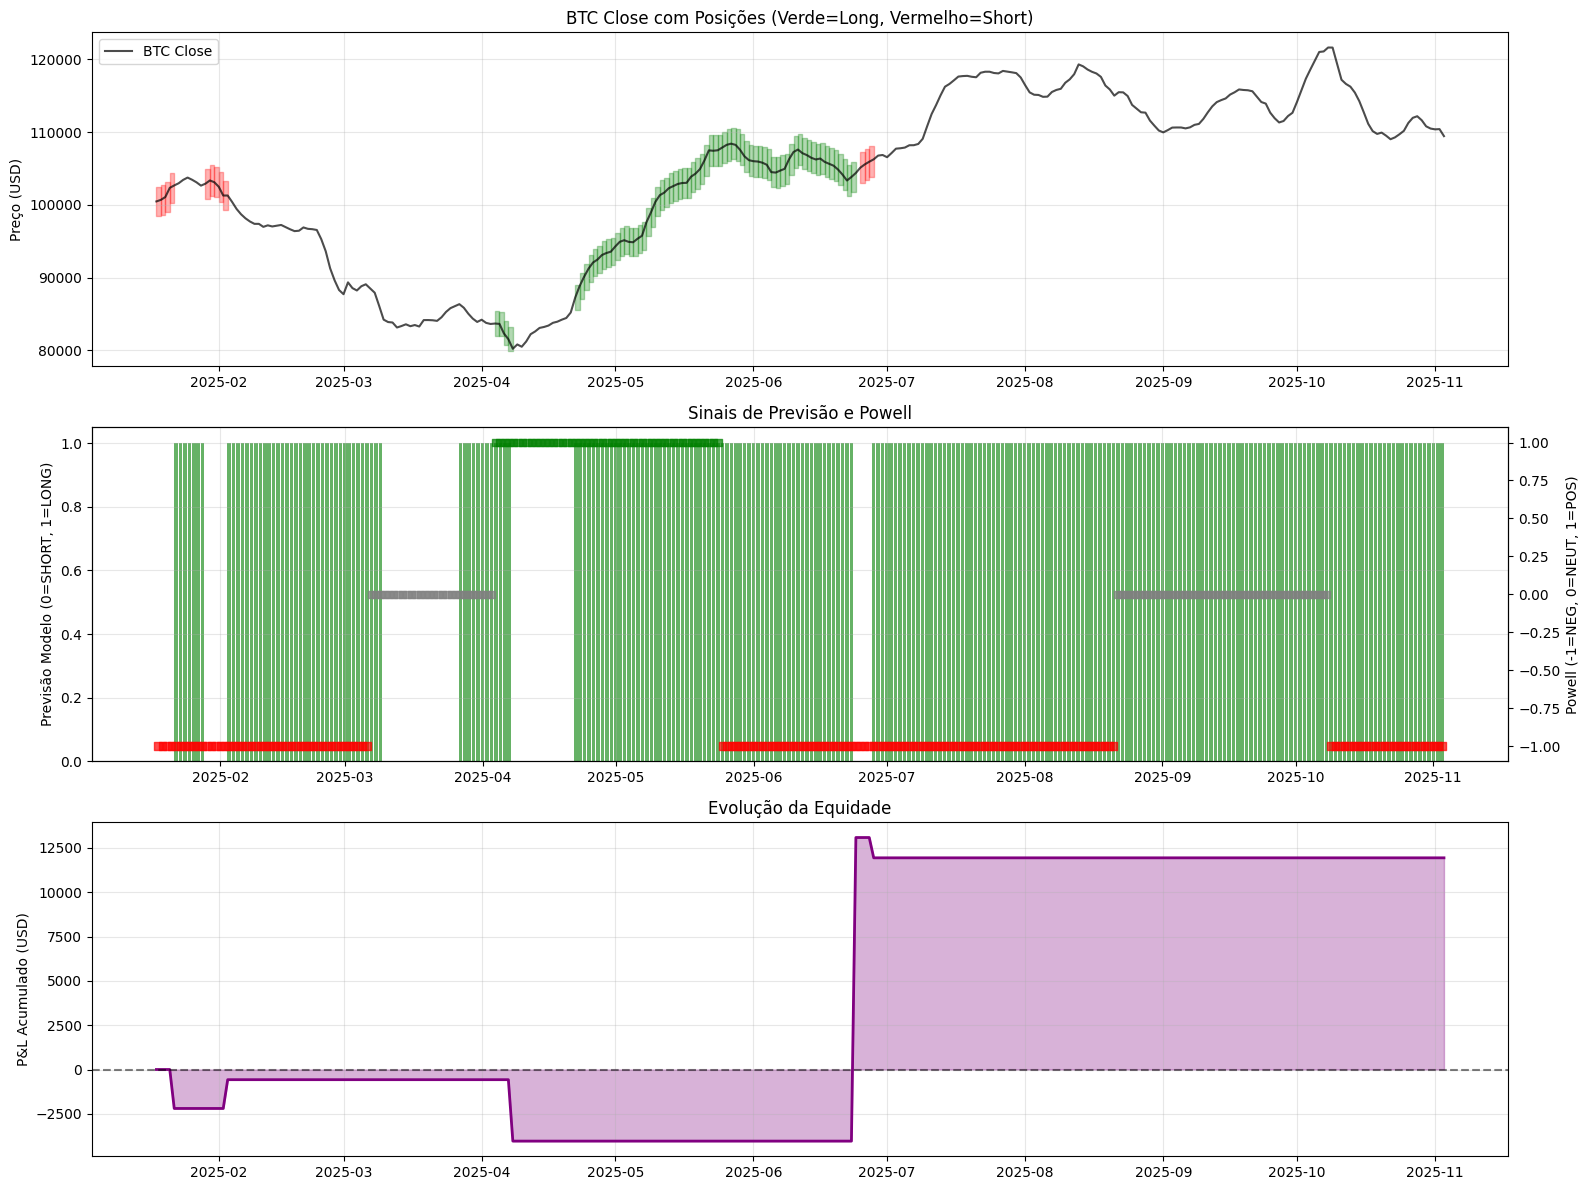

✓ Gráfico salvo em: data/backtest_analysis_new.png


In [11]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Eixo 1: Preço com posições
ax1 = axes[0]
dates = backtest_df["date"].values
closes = backtest_df["close"].values

ax1.plot(dates, closes, label="BTC Close", color="black", linewidth=1.5, alpha=0.7)

x = backtest_df["date"].values
y1 = closes * 0.98
y2 = closes * 1.02

# Colorir regiões por posição
for i in range(len(x)):
    pos = backtest_df["position"].iloc[i]
    if pos == 1:
        ax1.fill_between([x[i], x[i] if i == len(x)-1 else x[i+1]], y1[i], y2[i], alpha=0.3, color='green')
    elif pos == -1:
        ax1.fill_between([x[i], x[i] if i == len(x)-1 else x[i+1]], y1[i], y2[i], alpha=0.3, color='red')

ax1.set_ylabel("Preço (USD)")
ax1.set_title("BTC Close com Posições (Verde=Long, Vermelho=Short)")
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Eixo 2: Sinais do Modelo e Powell
ax2 = axes[1]
preds = backtest_df["pred"].values
powell = backtest_df["powell_class"].values

colors = ['green' if p == 1 else 'red' for p in preds]
ax2.bar(x, preds, color=colors, alpha=0.6, label='Modelo Pred')

ax2_twin = ax2.twinx()
powell_colors = ['green' if p == 1 else ('red' if p == -1 else 'gray') for p in powell]
ax2_twin.scatter(x, powell, color=powell_colors, s=30, alpha=0.7, label='Powell', marker='s')

ax2.set_ylabel("Previsão Modelo (0=SHORT, 1=LONG)")
ax2_twin.set_ylabel("Powell (-1=NEG, 0=NEUT, 1=POS)")
ax2.set_title("Sinais de Previsão e Powell")
ax2.grid(True, alpha=0.3)

# Eixo 3: Equidade (P&L acumulado)
ax3 = axes[2]
if len(trades_df) > 0:
    equity = []
    cumulative_pnl = 0
    for date in x:
        trades_to_date = trades_df[trades_df['exit_date'] <= date]
        cumulative_pnl = trades_to_date['pnl'].sum()
        equity.append(cumulative_pnl)
    
    ax3.plot(x, equity, color='purple', linewidth=2, label='Equidade Acumulada')
    ax3.fill_between(x, 0, equity, alpha=0.3, color='purple')
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_ylabel("P&L Acumulado (USD)")
    ax3.set_title("Evolução da Equidade")
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Sem trades para exibir', ha='center', va='center')

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "backtest_analysis_new.png"), dpi=100, bbox_inches="tight")
plt.show()

print(f"✓ Gráfico salvo em: data/backtest_analysis_new.png")

## 11. Tabela de Detalhes dos Trades

In [12]:
if len(trades_df) > 0:
    print("\n" + "="*100)
    print("DETALHAMENTO COMPLETO DE TODOS OS TRADES")
    print("="*100)
    print(trades_df.to_string(index=False))
else:
    print("\nNenhum trade foi executado neste período.")


DETALHAMENTO COMPLETO DE TODOS OS TRADES
 type entry_date  exit_date   entry_price    exit_price          pnl  return_pct
SHORT 2025-01-21 2025-01-22 100467.437993 102664.985068 -2197.547075   -2.187323
SHORT 2025-02-02 2025-02-03 102903.576834 101280.366475  1623.210359    1.577409
 LONG 2025-04-07 2025-04-08  83687.987554  80223.505046 -3464.482507   -4.139761
 LONG 2025-06-23 2025-06-24  87254.257081 104379.657567 17125.400486   19.627009
SHORT 2025-06-27 2025-06-28 105104.743175 106250.558840 -1145.815664   -1.090166


## 12. GRÁFICO 1: Backtest Analysis (3 Subplots)


✓ Gráfico 1 salvo em data/backtest_analysis.png


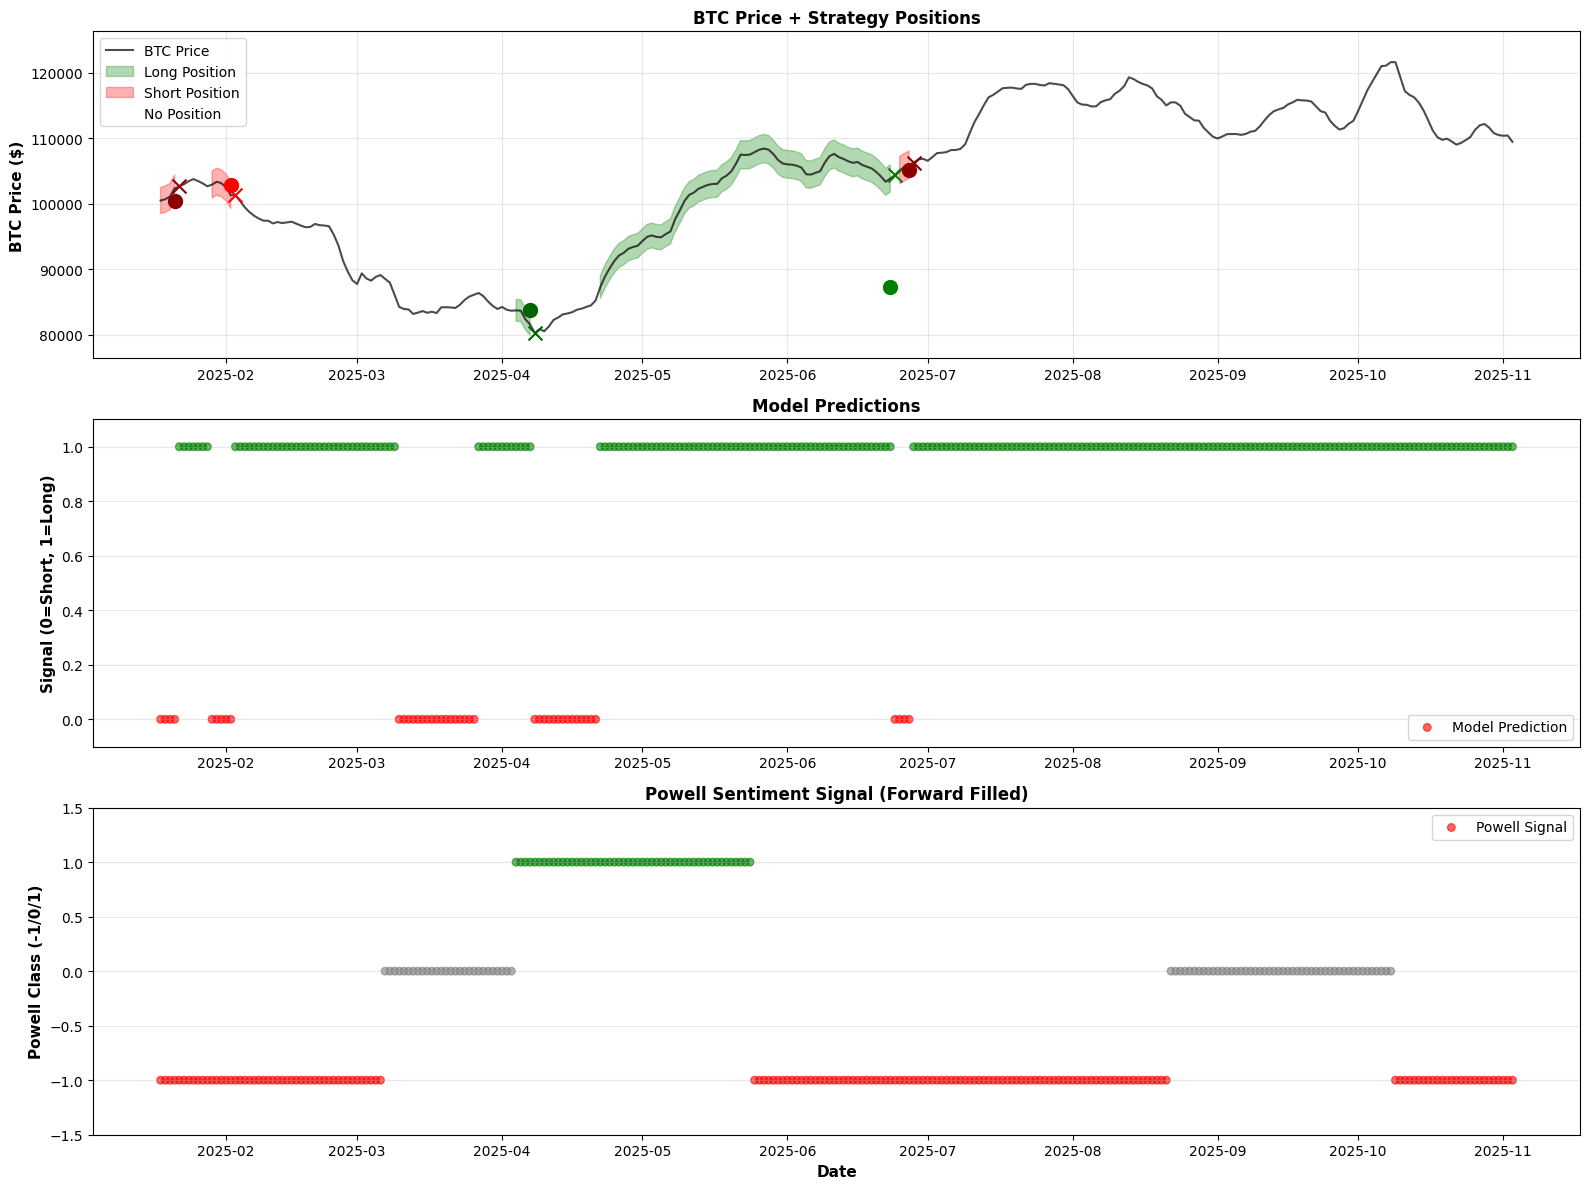

In [13]:

# ============================================================================
# GRÁFICO 1: Backtest Analysis (3 Subplots - Price, Predictions, Powell)
# ============================================================================

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Eixo 1: Preço BTC com Posições
ax1 = axes[0]
dates = backtest_df["date"].values
closes = backtest_df["close"].values

ax1.plot(dates, closes, label="BTC Price", color="black", linewidth=1.5, alpha=0.7)

x = backtest_df["date"].values
y1 = closes * 0.98
y2 = closes * 1.02

# Marcar posições com cores
long_mask  = backtest_df["position"] == 1
short_mask = backtest_df["position"] == -1
flat_mask  = backtest_df["position"] == 0

ax1.fill_between(x, y1, y2, where=long_mask,  color="green", alpha=0.3, label="Long Position")
ax1.fill_between(x, y1, y2, where=short_mask, color="red",   alpha=0.3, label="Short Position")
ax1.fill_between(x, y1, y2, where=flat_mask,  color="white", alpha=0.3, label="No Position")

# Marcar trades com pontos
for idx, trade in trades_df.iterrows():
    entry_price = trade["entry_price"]
    exit_price = trade["exit_price"]
    pnl = trade["pnl"]
    
    if trade["type"].startswith("LONG"):
        color = "green" if pnl > 0 else "darkgreen"
    else:
        color = "red" if pnl > 0 else "darkred"
    
    ax1.scatter(trade["entry_date"], entry_price, color=color, s=100, marker="o", zorder=5)
    ax1.scatter(trade["exit_date"], exit_price, color=color, s=100, marker="x", zorder=5)

ax1.set_ylabel("BTC Price ($)", fontsize=11, fontweight="bold")
ax1.set_title("BTC Price + Strategy Positions", fontsize=12, fontweight="bold")
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)

# Eixo 2: Sinais de Previsão
ax2 = axes[1]
colors_pred = ["red" if p == 0 else "green" for p in backtest_df["pred"]]
ax2.scatter(dates, backtest_df["pred"], c=colors_pred, s=30, alpha=0.6, label="Model Prediction")
ax2.set_ylabel("Signal (0=Short, 1=Long)", fontsize=11, fontweight="bold")
ax2.set_title("Model Predictions", fontsize=12, fontweight="bold")
ax2.set_ylim(-0.1, 1.1)
ax2.grid(True, alpha=0.3, axis="y")
ax2.legend()

# Eixo 3: Sinal Powell
ax3 = axes[2]
colors_powell = []
for p in backtest_df["powell_class"]:
    if p == 1:
        colors_powell.append("green")
    elif p == -1:
        colors_powell.append("red")
    else:
        colors_powell.append("gray")

ax3.scatter(dates, backtest_df["powell_class"], c=colors_powell, s=30, alpha=0.6, label="Powell Signal")
ax3.set_ylabel("Powell Class (-1/0/1)", fontsize=11, fontweight="bold")
ax3.set_xlabel("Date", fontsize=11, fontweight="bold")
ax3.set_title("Powell Sentiment Signal (Forward Filled)", fontsize=12, fontweight="bold")
ax3.set_ylim(-1.5, 1.5)
ax3.grid(True, alpha=0.3, axis="y")
ax3.legend()

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "backtest_analysis.png"), dpi=150, bbox_inches="tight")
print(f"\n✓ Gráfico 1 salvo em {os.path.join(DATA_DIR, 'backtest_analysis.png')}")
plt.show()


## 13. GRÁFICO 2: Equity Curve

✓ Gráfico 2 salvo em data/equity_curve.png


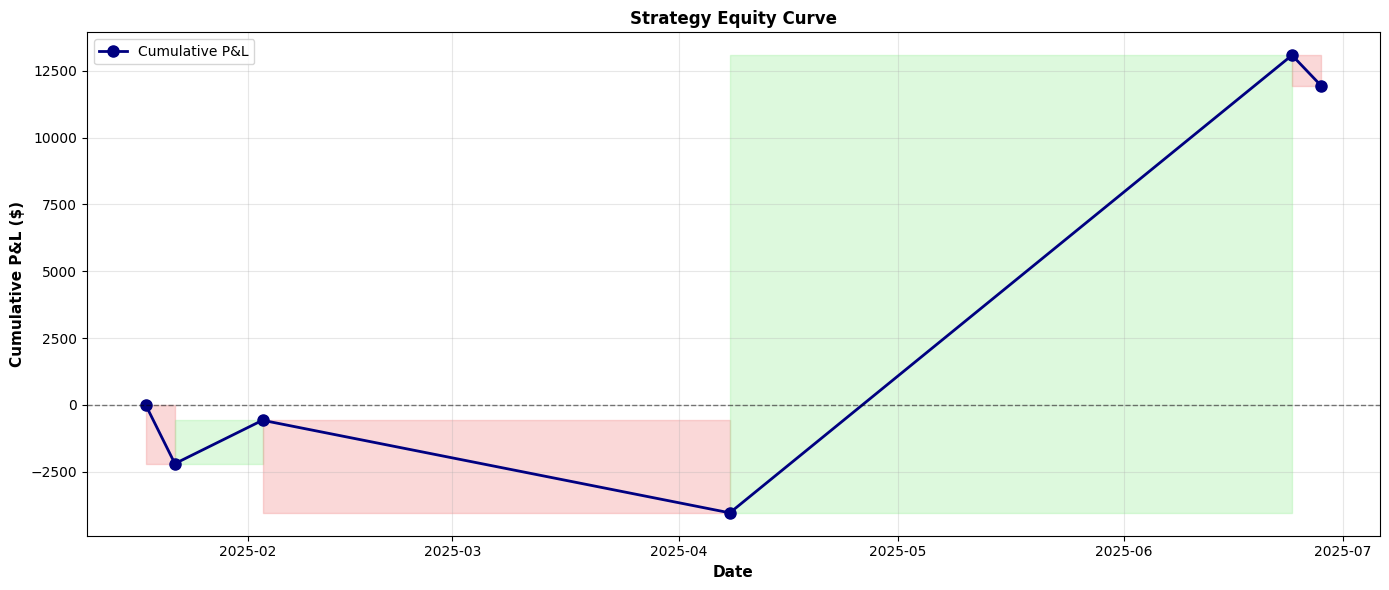

In [14]:

# ============================================================================
# GRÁFICO 2: Equity Curve (Curva de Lucro Acumulado)
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 6))

# Calcular equity curve baseado em trades
equity = [0]
trade_dates = [backtest_df["date"].iloc[0]]

for idx, trade in trades_df.iterrows():
    equity.append(equity[-1] + trade["pnl"])
    trade_dates.append(trade["exit_date"])

# Plotar equity curve
ax.plot(trade_dates, equity, marker="o", linewidth=2, markersize=8, color="navy", label="Cumulative P&L")
ax.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.5)

# Colorir fundo baseado em ganhos/perdas
for i in range(len(equity)-1):
    color = "lightgreen" if equity[i+1] > equity[i] else "lightcoral"
    ax.fill_between([trade_dates[i], trade_dates[i+1]], equity[i], equity[i+1], 
                    alpha=0.3, color=color)

ax.set_xlabel("Date", fontsize=11, fontweight="bold")
ax.set_ylabel("Cumulative P&L ($)", fontsize=11, fontweight="bold")
ax.set_title("Strategy Equity Curve", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "equity_curve.png"), dpi=150, bbox_inches="tight")
print(f"✓ Gráfico 2 salvo em {os.path.join(DATA_DIR, 'equity_curve.png')}")
plt.show()


## 14. GRÁFICO 3: Returns Distribution

✓ Gráfico 3 salvo em data/returns_distribution.png


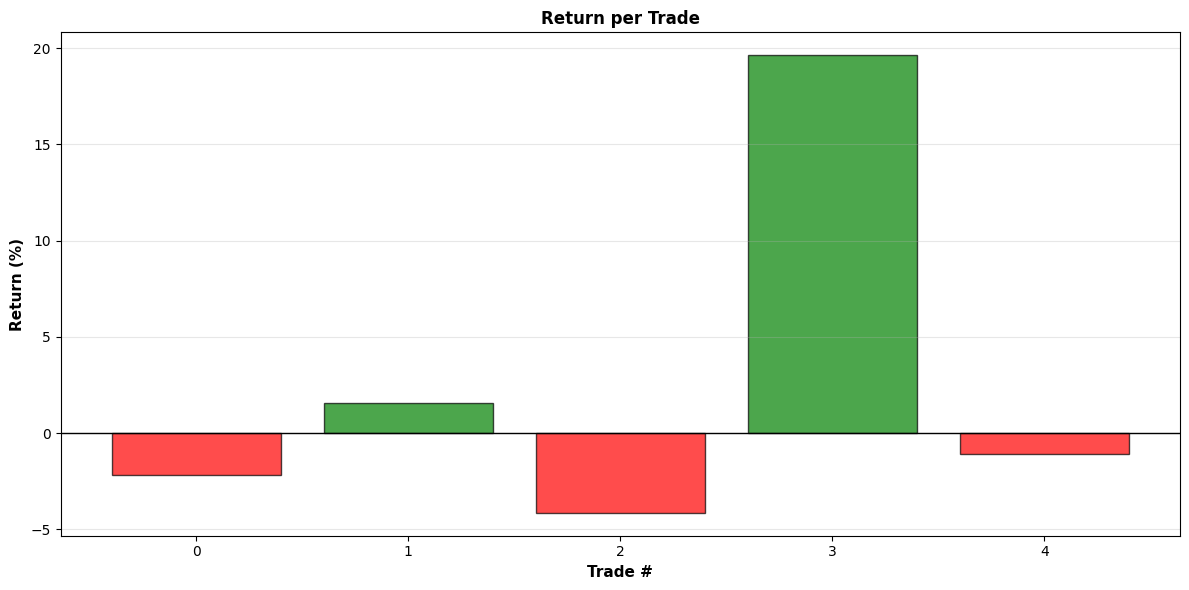

In [15]:

# ============================================================================
# GRÁFICO 3: Distribuição de Returns
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 6))

returns = trades_df["return_pct"].values
colors_return = ["green" if r > 0 else "red" for r in returns]

bars = ax.bar(range(len(returns)), returns, color=colors_return, alpha=0.7, edgecolor="black")
ax.axhline(y=0, color="black", linestyle="-", linewidth=1)
ax.set_xlabel("Trade #", fontsize=11, fontweight="bold")
ax.set_ylabel("Return (%)", fontsize=11, fontweight="bold")
ax.set_title("Return per Trade", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "returns_distribution.png"), dpi=150, bbox_inches="tight")
print(f"✓ Gráfico 3 salvo em {os.path.join(DATA_DIR, 'returns_distribution.png')}")
plt.show()


## 15. Resumo Estatístico Completo

In [ ]:

# ============================================================================
# SUMÁRIO ESTATÍSTICO COMPLETO
# ============================================================================

print("\n" + "="*80)
print("RESUMO ESTATÍSTICO DO BACKTEST")
print("="*80)

if len(trades_df) > 0:
    # Métricas básicas
    total_trades = len(trades_df)
    total_pnl = trades_df["pnl"].sum()
    total_return_pct = (total_pnl / backtest_df["close"].iloc[0] * 100) if backtest_df["close"].iloc[0] > 0 else 0
    
    # Winning and losing trades
    winning = trades_df[trades_df["pnl"] > 0]
    losing = trades_df[trades_df["pnl"] < 0]
    n_wins = len(winning)
    n_losses = len(losing)
    win_rate = (n_wins / total_trades * 100) if total_trades > 0 else 0
    
    # P&L statistics
    avg_win = winning["pnl"].mean() if len(winning) > 0 else 0
    avg_loss = losing["pnl"].mean() if len(losing) > 0 else 0
    max_win = winning["pnl"].max() if len(winning) > 0 else 0
    max_loss = losing["pnl"].min() if len(losing) > 0 else 0
    
    # Return statistics
    avg_return_win = winning["return_pct"].mean() if len(winning) > 0 else 0
    avg_return_loss = losing["return_pct"].mean() if len(losing) > 0 else 0
    
    # Profit factor
    gross_profit = winning["pnl"].sum() if len(winning) > 0 else 0
    gross_loss = abs(losing["pnl"].sum()) if len(losing) > 0 else 0
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else (float('inf') if gross_profit > 0 else 0)
    
    print(f"\nTotais:")
    print(f"  Total de Trades: {total_trades}")
    print(f"  Total P&L: ${total_pnl:+.2f}")
    print(f"  Total Return: {total_return_pct:+.2f}%")
    
    print(f"\nWin/Loss:")
    print(f"  Trades Vencedores: {n_wins} ({win_rate:.1f}%)")
    print(f"  Trades Perdedores: {n_losses}")
    
    print(f"\nP&L por Trade:")
    print(f"  Avg Win: ${avg_win:+.2f} ({avg_return_win:+.2f}%)")
    print(f"  Avg Loss: ${avg_loss:+.2f} ({avg_return_loss:+.2f}%)")
    print(f"  Max Win: ${max_win:+.2f}")
    print(f"  Max Loss: ${max_loss:+.2f}")
    
    print(f"\nRazões:")
    print(f"  Profit Factor: {profit_factor:.2f}" if profit_factor != float('inf') else f"  Profit Factor: ∞")
    if len(winning) > 0 and len(losing) > 0:
        print(f"  Avg Win / Avg Loss: {abs(avg_win / avg_loss):.2f}" if avg_loss != 0 else "  Avg Win / Avg Loss: ∞")
    
    print(f"\nDuração dos Trades:")
    trades_df["duration"] = (trades_df["exit_date"] - trades_df["entry_date"]).dt.days
    print(f"  Média: {trades_df['duration'].mean():.1f} dias")
    print(f"  Min: {trades_df['duration'].min()} dias")
    print(f"  Max: {trades_df['duration'].max()} dias")
else:
    print("Nenhum trade foi executado!")

print("\n" + "="*80)
